In [2]:
# This cell is used to unzip the faces dataset.
import zipfile

with zipfile.ZipFile("../datasets/smiles.zip", 'r') as zip_ref:
    zip_ref.extractall("datasets/")

In [5]:
import os
import shutil

# RUTAS (ajusta según tu estructura)
BASE_DIR = "datasets/smiles/"
IMG_DIR = os.path.join(BASE_DIR, "faces")

SMILE_TXT = os.path.join(BASE_DIR, "lists", "SMILE_list.txt")
NOT_SMILE_TXT = os.path.join(BASE_DIR, "lists", "NON-SMILE_list.txt")

OUT_SMILE = os.path.join(BASE_DIR, "smile")
OUT_NOT_SMILE = os.path.join(BASE_DIR, "not_smile")

os.makedirs(OUT_SMILE, exist_ok=True)
os.makedirs(OUT_NOT_SMILE, exist_ok=True)

def mover_imagenes(lista_txt, destino):
    with open(lista_txt, "r") as f:
        for line in f:
            nombre = line.strip()
            if not nombre:
                continue

            # quitar extensión original (.jpg) y construir .ppm
            base = os.path.splitext(nombre)[0]   # "sujeto01_smile"
            candidato_ppm = os.path.join(IMG_DIR, base + ".ppm")

            if os.path.exists(candidato_ppm):
                shutil.copy2(candidato_ppm, os.path.join(destino, os.path.basename(candidato_ppm)))
            else:
                print(f"No encontré el archivo para: {nombre} -> {candidato_ppm}")

# Ejecutar para cada lista
mover_imagenes(SMILE_TXT, OUT_SMILE)
mover_imagenes(NOT_SMILE_TXT, OUT_NOT_SMILE)

No encontré el archivo para: listt.txt -> datasets/smiles/faces/listt.ppm
No encontré el archivo para: SMILE_list.txt -> datasets/smiles/faces/SMILE_list.ppm


In [6]:
from PIL import Image
import glob
import os

def convertir_ppm_a_jpg_y_borrar(carpeta):
    for ppm_path in glob.glob(os.path.join(carpeta, "*.ppm")):
        # Convertir ppm a jpg
        img = Image.open(ppm_path)
        jpg_path = os.path.splitext(ppm_path)[0] + ".jpg"
        img.save(jpg_path)

        # Si el jpg fue creado correctamente, borrar el ppm
        if os.path.exists(jpg_path):
            os.remove(ppm_path)
          #print(f"Convertido y borrado: {ppm_path}")
        else:
          print(f"ERROR: no se generó el JPG para {ppm_path}")

# Ejecutar sobre ambas carpetas
convertir_ppm_a_jpg_y_borrar(OUT_SMILE)
convertir_ppm_a_jpg_y_borrar(OUT_NOT_SMILE)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

2025-12-03 12:48:22.719213: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-03 12:48:22.726981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 12:48:23.003663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 12:48:24.259920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
rootpath = "/home/bingus/TEC/Semestre_5/Neural_Networks/notebooks/datasets/smiles/"

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import os

# === Cargar imágenes como ya tienes ===
files_smile = os.listdir(rootpath + "smile/")
files_non_smile = os.listdir(rootpath + "not_smile/")

max_n = 2500
n = min(max_n, len(files_smile), len(files_non_smile))
print("Voy a usar n =", n)

target_size = (304, 304)

imgs_smiles = []
imgs_non = []

for i in range(n):
    img = image.load_img(rootpath + "smile/" + files_smile[i], target_size=target_size)
    img = image.img_to_array(img) / 255.0
    imgs_smiles.append(img)

    img2 = image.load_img(rootpath + "not_smile/" + files_non_smile[i], target_size=target_size)
    img2 = image.img_to_array(img2) / 255.0
    imgs_non.append(img2)

imgs_smile = np.array(imgs_smiles)
imgs_non = np.array(imgs_non)

# === Crear dataset combinado ===
X = np.concatenate((imgs_smile, imgs_non), axis=0)

# Crear etiquetas: 1 para smile, 0 para not_smile
y = np.concatenate((np.ones(len(imgs_smile)), np.zeros(len(imgs_non))))

# === Mezclar aleatoriamente ===
np.random.seed(123)
idxs = np.random.permutation(len(X))
X = X[idxs]
y = y[idxs]

# === Dividir en train y test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Voy a usar n = 600
Train: (960, 304, 304, 3) Test: (240, 304, 304, 3)


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

dropout_rate = 0.5

inputs = Input(shape=(304, 304, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_rate)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)

model.summary()


2025-12-03 12:57:27.218979: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 304, 304, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 304, 304, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 304, 304, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 152, 152, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 152, 152, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 152, 152, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 76, 76, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 184832)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,658,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,752,897 (90.61 MB)

 Trainable params: 23,752,449 (90.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8984 - loss: 1.2811 - val_accuracy: 0.5104 - val_loss: 33.0187
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8906 - loss: 1.5640 - val_accuracy: 0.5104 - val_loss: 80.3494
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8893 - loss: 0.5381 - val_accuracy: 0.5104 - val_loss: 76.2073
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8971 - loss: 0.4531 - val_accuracy: 0.5104 - val_loss: 77.2669
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8893 - loss: 0.7130 - val_accuracy: 0.5104 - val_loss: 45.9084
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9141 - loss: 0.3559 - val_accuracy: 0.5104 - val_loss: 72.1442
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9206 - loss: 0.3401 - val_accuracy: 0.5625 - val_loss: 30.8251
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9414 - loss: 0.1948 - val_accuracy: 0.5208 - va

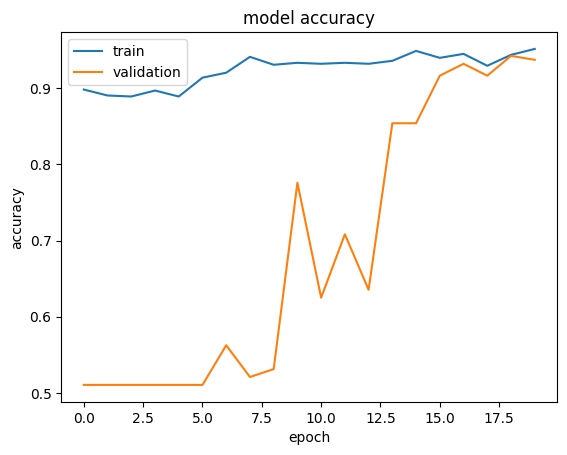

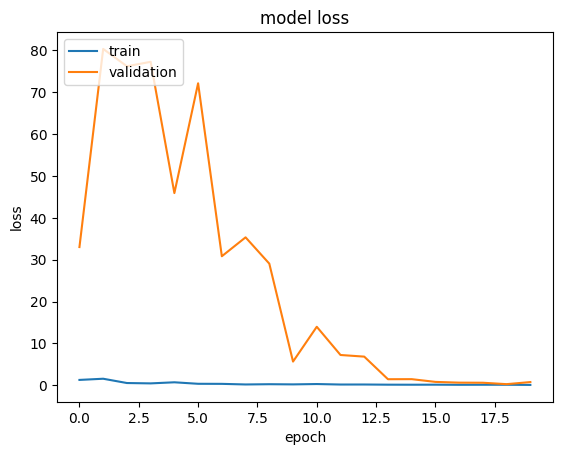

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
# Evaluate the model and print accuracy.
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.9000 - loss: 1.1361
Test accuracy: 0.8999999761581421
